# Multi-Modal

In this notebook, we show how to use Anthropic MultiModal LLM class/abstraction for image understanding/reasoning.

#### Installation

In [ ]:
!pip install llama-index
!pip install llama-index-multi-modal-llms-anthropic
!pip install llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-qdrant
!pip install matplotlib

#### Setup API key

In [1]:
import os
os.environ['ANTHROPIC_API_KEY'] = 'YOUR ANTHROPIC API KEY'

#### Download Sample Images

In [2]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/images/prometheus_paper_card.png' -O 'prometheus_paper_card.png'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/images/ark_email_sample.PNG' -O 'ark_email_sample.png'

--2024-03-08 11:53:40--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/images/prometheus_paper_card.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002436 (979K) [image/png]
Saving to: ‘prometheus_paper_card.png’

prometheus_paper_ca 100%[===================>] 978.94K  --.-KB/s    in 0.005s  

2024-03-08 11:53:40 (175 MB/s) - ‘prometheus_paper_card.png’ saved [1002436/1002436]

--2024-03-08 11:53:40--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/images/ark_email_sample.PNG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... c

####  Use Anthropic to understand Images from Local directory

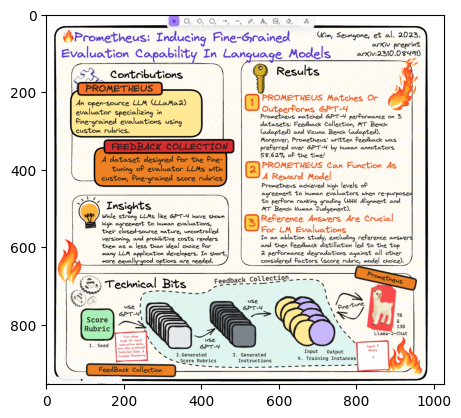

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML

img = Image.open("./prometheus_paper_card.png")
plt.imshow(img)

In [4]:
from llama_index.core import SimpleDirectoryReader
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

image_documents = SimpleDirectoryReader(
    input_files=["prometheus_paper_card.png"]
).load_data()

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

In [5]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [6]:
print(response)

The image is a diagram titled "Prometheus: Inducing Fine-Grained Evaluation Capability In Language Models". It outlines the key components and workflow of the Prometheus system.

The main sections are:
1. Contributions: Describes Prometheus as an open-source LLM evaluator that uses custom rubrics for fine-grained evaluations.
2. Feedback Collection: A dataset for fine-tuning evaluator LLMs with custom, fine-grained score rubrics. This section visually shows the process of seeding score rubrics, generating scores, generating instructions, and outputting training instances to create the Feedback Collection.
3. Results: Lists 3 key results - Prometheus matches or outperforms GPT-4 on 3 evaluation datasets, can function as a reward model to help LLMs achieve high agreement with human evaluators on ranking, and enables reference answers for LM evaluations via an ablation study and feedback distillation.
4. Insights: Notes that strong LLMs like GPT-4 show high agreement with human evaluation

#### Use `AnthropicMultiModal` to reason images from URLs

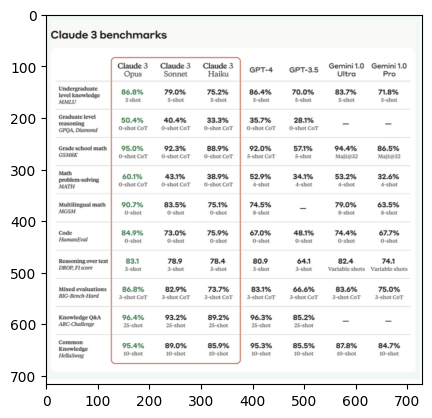

In [7]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

image_urls = [
    "https://venturebeat.com/wp-content/uploads/2024/03/Screenshot-2024-03-04-at-12.49.41%E2%80%AFAM.png",
]

img_response = requests.get(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

#### Load images with url

In [8]:
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_url_documents = load_image_urls(image_urls)

In [9]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_url_documents,
)

In [10]:
print(response)

The image shows a table comparing the benchmark scores of various Claude 3 AI models (Opus, Sonnet, Haiku) against GPT-4, GPT-3.5, and two versions of Gemini (1.0 Ultra and 1.0 Pro) across different academic subjects and tests.

The subjects covered include undergraduate and graduate level knowledge, grade school math, math problem-solving, multilingual math, code, reasoning over text, mixed evaluations, knowledge Q&A, and common knowledge.

The scores are presented as percentages, except for the "Reasoning over text" row which shows raw scores out of a certain number of shots.

Overall, the Claude 3 models show competitive performance compared to the GPT and Gemini models across most of the benchmarks. The Gemini models have a slight edge in some categories like undergraduate knowledge and math problem-solving.


#### Structured Output Parsing from an Image

Here, we use our multi-modal Pydantic program to generate structured output from an image.

In [11]:
from llama_index.core import SimpleDirectoryReader

image_documents = SimpleDirectoryReader(
    input_files=["ark_email_sample.png"]
).load_data()

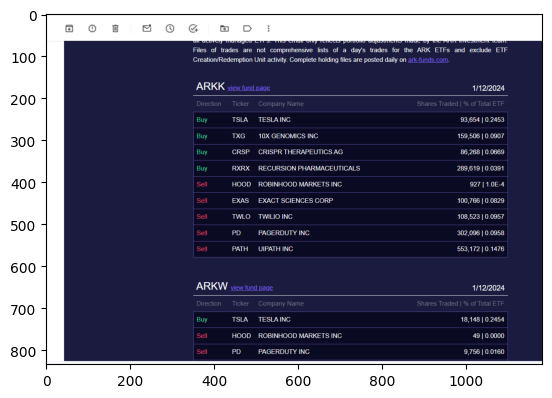

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("ark_email_sample.png")
plt.imshow(img)

In [13]:
from pydantic import BaseModel
from typing import List


class TickerInfo(BaseModel):
    """List of ticker info."""

    direction: str
    ticker: str
    company: str
    shares_traded: int
    percent_of_total_etf: float


class TickerList(BaseModel):
    """List of stock tickers."""

    fund: str
    tickers: List[TickerInfo]

In [14]:
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
Can you get the stock information in the image \
and return the answer? Pick just one fund. 

Make sure the answer is a JSON format corresponding to a Pydantic schema. The Pydantic schema is given below.

"""

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)


llm_program = MultiModalLLMCompletionProgram.from_defaults(
    output_cls=TickerList,
    image_documents=image_documents,
    prompt_template_str=prompt_template_str,
    multi_modal_llm=anthropic_mm_llm,
    verbose=True,
)

In [15]:
response = llm_program()

> Raw output: {
  "fund": "ARKK",
  "tickers": [
    {
      "direction": "Buy",
      "ticker": "TSLA",
      "company": "TESLA INC",
      "shares_traded": 93664,
      "percent_of_total_etf": 0.2453
    }
  ]
}


In [16]:
print(response)

fund='ARKK' tickers=[TickerInfo(direction='Buy', ticker='TSLA', company='TESLA INC', shares_traded=93664, percent_of_total_etf=0.2453)]
